In [1]:
%matplotlib notebook

from __future__ import division
#from __future__ import print_function
import matplotlib
#matplotlib.use('TkAgg')
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
import cv2
import glob
import numpy as np
import os
from scipy.sparse import spdiags, issparse

# import caiman
from caiman.base.rois import com
import caiman as cm

import time
import pylab as pl

import re
import json
import h5py
import cPickle as pkl
import scipy.io
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pprint

pp = pprint.PrettyPrinter(indent=4)

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def serialize_json(instance=None, path=None):
    dt = {}
    dt.update(vars(instance))

def byteify(input):
    if isinstance(input, dict):
        return {byteify(key): byteify(value)
                for key, value in input.iteritems()}
    elif isinstance(input, list):
        return [byteify(element) for element in input]
    elif isinstance(input, unicode):
        return input.encode('utf-8')
    else:
        return input


numba not found
KERAS NOT INSTALLED. IF YOU WANT TO USE THE CNN BASED COMPONENT CLASSIFIER (experimental) CONTACT THE DEVELOPERS


In [2]:
#%%
source = '/nas/volume1/2photon/projects'
experiment = 'gratings_phaseMod'
session = '20171009_CE059'
acquisition = 'FOV1_zoom3x'
functional = 'functional'

roi_id = 'caiman2Dnmf002'
roi_method = 'caiman2D'


In [3]:
acquisition_dir = os.path.join(source, experiment, session, acquisition)

acquisition_meta_fn = os.path.join(acquisition_dir, 'reference_%s.json' % functional)
with open(acquisition_meta_fn, 'r') as f:
    acqmeta = json.load(f)

roi_dir = os.path.join(acqmeta['roi_dir'], roi_id)
roiparams_path = os.path.join(roi_dir, 'roiparams.json')
with open(roiparams_path, 'r') as f:
    roiparams = json.load(f)

roiparams = byteify(roiparams)
if not roi_id==roiparams['roi_id']:
    print("***WARNING***")
    print("Loaded ROIPARAMS id doesn't match user-specified roi_id.")
    pp.pprint(roiparams)
    use_loaded = raw_input('Use loaded ROIPARAMS? Press Y/n: ')
    if use_loaded=='Y':
        roi_id = roiparams['roi_id']
   

In [4]:
#%%
# Load mcparams.mat:
mcparams = scipy.io.loadmat(acqmeta['mcparams_path'])
mc_ids = sorted([m for m in mcparams.keys() if 'mcparams' in m], key=natural_keys)
if len(mc_ids)>1:
    for mcidx,mcid in enumerate(sorted(mc_ids, key=natural_keys)):
        print(mcidx, mcid)
    mc_id_idx = raw_input('Select IDX of mc-method to use: ')
    mc_id = mc_ids[int(mc_id_idx)]
    print("Using MC-METHOD: ", mc_id)
else:
    mc_id = mc_ids[0]

mcparams = mcparams[mc_id] #mcparams['mcparams01']
reference_file_idx = int(mcparams['ref_file'])
signal_channel_idx = int(mcparams['ref_channel'])

signal_channel = 'Channel%02d' % int(signal_channel_idx)
reference_file = 'File%03d' % int(reference_file_idx)
if signal_channel_idx==0:
    signal_channel_idx = input('No ref channel found. Enter signal channel idx (1-indexing): ')
if reference_file_idx==0:
    reference_file_idx = input('No ref file found. Enter file idx (1-indexing): ')

signal_channel = 'Channel%02d' % int(signal_channel_idx)
reference_file = 'File%03d' % int(reference_file_idx)
print("Specified signal channel is:", signal_channel)
print("Selected reference file:", reference_file)
#del mcparams


if isinstance(acqmeta['slices'], int):
    nslices = acqmeta['slices']
else:
    nslices = len(acqmeta['slices'])
    
print(nslices)

('Specified signal channel is:', 'Channel01')
('Selected reference file:', 'File006')
1


In [5]:
#%% 

# source of NMF output run:
nmf_output_dir = os.path.join(roi_dir, 'nmf_output')
nmf_fns = sorted([n for n in os.listdir(nmf_output_dir) if n.endswith('npz')], key=natural_keys)

file_names = sorted(['File%03d' % int(f+1) for f in range(acqmeta['ntiffs'])], key=natural_keys)
if not len(file_names)==len(nmf_fns):
    print('***ALERT***')
    print('Found NMF results does not match num tiff files.')

# Get source tiffs (mmap):
tiff_source = str(mcparams['dest_dir'][0][0][0])
tiff_dir = os.path.join(acquisition_dir, functional, 'DATA', tiff_source)
#tiff_dir

# Get mmap tiffs:
memmapped_fns = sorted([m for m in os.listdir(tiff_dir) if m.endswith('mmap')], key=natural_keys)

###  Load REF-NMF to get first set of ROIs:

In [6]:
ref_nmf_fn = [f for f in nmf_fns if reference_file in f][0]
refnmf = np.load(os.path.join(nmf_output_dir, ref_nmf_fn))
print refnmf.keys()

['r_values', 'fitness_raw', 'idx_components', 'fitness_delta', 'd2', 'd1', 'YrA', 'neurons_sn', 'idx_components_bad', 'A', 'lam', 'C', 'bl', 'dims', 'S', 'c1', 'Cdf', 'b', 'Cn', 'g', 'f', 'sn', 'Av']


In [21]:
nr = refnmf['A'].all().shape[1]
d1 = int(refnmf['d1'])
d2 = int(refnmf['d2'])

A1 = refnmf['A'].all()
# A2 = A.copy()
# A2.data **= 2
# nA = np.sqrt(np.array(A2.sum(axis=0))).squeeze()

# rA = A * spdiags(old_div(1, nA), 0, nr, nr)
# rA = rA.todense()
masks = np.reshape(np.array(A1.todense()), (d1, d2, nr), order='F')
print masks.shape

(512, 512, 56)


<IPython.core.display.Javascript object>


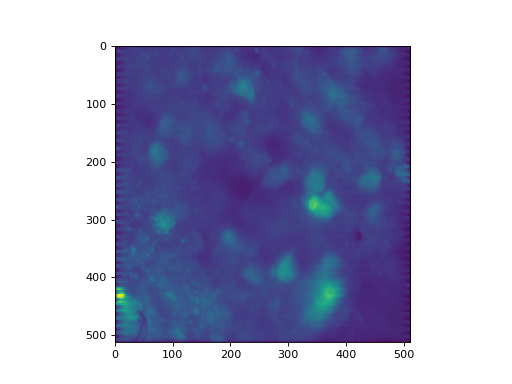

In [22]:
# Get average image

if not 'Av' in refnmf.keys():
    img = np.mean(masks[:,:,:-1], axis=-1)
else: 
    img = refnmf['Av']

pl.figure()
pl.imshow(img)


<IPython.core.display.Javascript object>


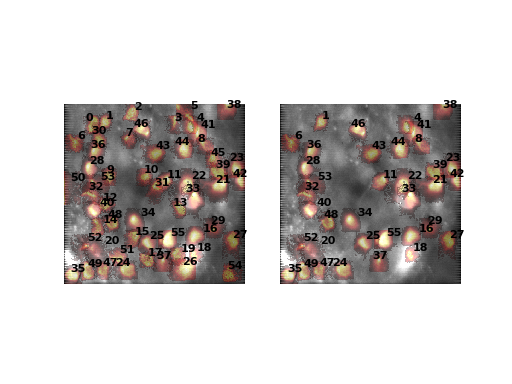

(512, 512, 36)


In [11]:
vmax = np.percentile(img, 98)
pl.figure()

pl.subplot(1,2,1)
pl.imshow(img, interpolation='None', cmap=pl.cm.gray, vmax=vmax)
for roi in range(nr):
    masktmp = masks[:,:,roi]
    msk = masktmp.copy() 
    msk[msk==0] = np.nan
    pl.imshow(msk, interpolation='None', alpha=0.3, cmap=pl.cm.hot)
    [ys, xs] = np.where(masktmp>0)
    pl.text(xs[int(round(len(xs)/4))], ys[int(round(len(ys)/4))], str(roi), weight='bold')

    pl.axis('off')

pl.subplot(1,2,2)
pl.imshow(img, interpolation='None', cmap=pl.cm.gray, vmax=vmax)
kept_rois = refnmf['idx_components']
masks_kept = masks[:,:,kept_rois]
print masks_kept.shape
nr_kept = masks_kept.shape[-1]
for roi in range(nr_kept):
    masktmp = masks_kept[:,:,roi]
    msk = masktmp.copy() 
    msk[msk==0] = np.nan
    pl.imshow(msk, interpolation='None', alpha=0.3, cmap=pl.cm.hot)
    [ys, xs] = np.where(masktmp>0)
    pl.text(xs[int(round(len(xs)/4))], ys[int(round(len(ys)/4))], str(kept_rois[roi]), weight='bold')

    pl.axis('off')

### Load another file to coregister:

In [15]:
curr_file = 'File001'

In [16]:
nmf_fn = [f for f in nmf_fns if curr_file in f][0]
nmf = np.load(os.path.join(nmf_output_dir, nmf_fn))
print nmf.keys()

['r_values', 'fitness_raw', 'idx_components', 'fitness_delta', 'd2', 'd1', 'YrA', 'neurons_sn', 'idx_components_bad', 'A', 'lam', 'C', 'bl', 'dims', 'S', 'c1', 'Cdf', 'b', 'Cn', 'g', 'f', 'sn', 'Av']


In [23]:
nr = nmf['A'].all().shape[1]
d1 = int(nmf['d1'])
d2 = int(nmf['d2'])

A2 = nmf['A'].all()
# A2 = A.copy()
# A2.data **= 2
# nA = np.sqrt(np.array(A2.sum(axis=0))).squeeze()

# rA = A * spdiags(old_div(1, nA), 0, nr, nr)
# rA = rA.todense()
# masks = np.reshape(np.array(rA), (d1, d2, nr), order='F')

masks2 = np.reshape(np.array(A2.todense()), (d1, d2, nr), order='F')
print masks2.shape

(512, 512, 59)


### Transform refnmf masks into binary masks:

In [31]:
M1 = A1.astype('bool').toarray()

In [32]:
M2 = A2.astype('bool').toarray()

In [33]:
K1 = A1.shape[-1]
K2 = A2.shape[-1]
print "K1", K1, "K2", K2

K1 56 K2 59


In [34]:
max(K1,K2)

59

In [105]:
options = dict()
# dist_maxthr:      threshold for turning spatial components into binary masks (default: 0.1)
# dist_exp:         power n for distance between masked components: dist = 1 - (and(m1,m2)/or(m1,m2))^n (default: 1)
# dist_thr:         threshold for setting a distance to infinity. (default: 0.5)
# dist_overlap_thr: overlap threshold for detecting if one ROI is a subset of another (default: 0.8)
    
options['dist_maxthr'] = 0.1
options['dist_exp'] = 1
options['dist_thr'] = 0.5
options['dist_overlap_thr'] = 0.8

In [40]:
i = 0
A_temp = A1.toarray()[:,i]
M1[A_temp>options['dist_maxthr']*max(A_temp),i] = True

In [44]:
M1.shape

(262144, 56)

<IPython.core.display.Javascript object>


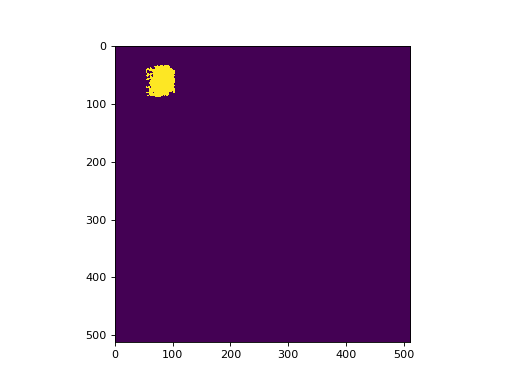

In [46]:
pl.figure();
pl.imshow(np.reshape(M1, (d1, d2, M1.shape[1]), order='F')[:,:,0])

In [74]:
s = ndimage.generate_binary_structure(2,1)
print s

[[False  True False]
 [ True  True  True]
 [False  True False]]


In [75]:
from scipy import ndimage

labeled, nr_objects = ndimage.label(np.reshape(M1[:,i], (d1,d2), order='F'), s)

In [76]:
print labeled.shape
print nr_objects

(512, 512)
3


In [86]:
sizes = ndimage.sum(np.reshape(M1[:,i], (d1,d2), order='F'),labeled,range(1,nr_objects+1)) 
print sizes
maxp = np.where(sizes==sizes.max())[0] + 1 
print maxp

minp = np.where(sizes==sizes.min())[0] + 1
print minp

[  2.19300000e+03   2.40000000e+01   1.00000000e+00]
[1]
[3]


In [90]:
# inside the largest, respecitively the smallest labeled patches with values
max_index = np.zeros(nr_objects + 1, np.uint8)
max_index[maxp] = 1
max_feature = max_index[labeled]

min_index = np.zeros(nr_objects + 1, np.uint8)
min_index[minp] = 1
min_feature = min_index[labeled]

In [93]:
np.where(min_feature>0)

(array([66]), array([58]))

<IPython.core.display.Javascript object>


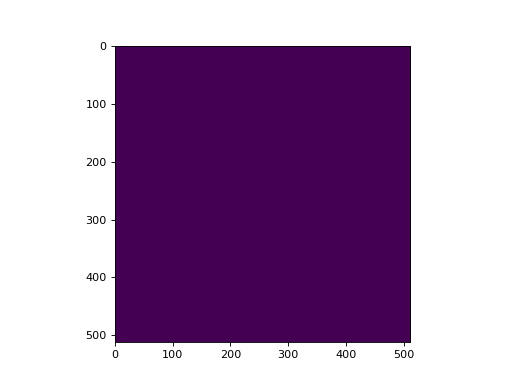

In [94]:
pl.figure()
#pl.subplot(1,2,1)
#pl.imshow(max_feature)
#pl.subplot(1,2,2)
pl.imshow(min_feature)

In [110]:
s = ndimage.generate_binary_structure(2,1)

for i in np.arange(0, max(K1,K2)):
    if i < K1:
        A_temp = A1.toarray()[:,i]
        M1[A_temp>options['dist_maxthr']*max(A_temp),i] = True
        labeled, nr_objects = ndimage.label(np.reshape(M1[:,i], (d1,d2), order='F'), s)  # keep only the largest connected component
        sizes = ndimage.sum(np.reshape(M1[:,i], (d1,d2), order='F'), labeled, range(1,nr_objects+1)) 
        maxp = np.where(sizes==sizes.max())[0] + 1 
        max_index = np.zeros(nr_objects + 1, np.uint8)
        max_index[maxp] = 1
        BW = max_index[labeled]
        M1[:,i] = np.reshape(BW, M1[:,i].shape, order='F')
    if i < K2:
        A_temp = A2.toarray()[:,i];
        M2[A_temp>options['dist_maxthr']*max(A_temp),i] = True
        labeled, nr_objects = ndimage.label(np.reshape(M2[:,i], (d1,d2), order='F'), s)  # keep only the largest connected component
        sizes = ndimage.sum(np.reshape(M2[:,i], (d1,d2), order='F'), labeled, range(1,nr_objects+1)) 
        maxp = np.where(sizes==sizes.max())[0] + 1 
        max_index = np.zeros(nr_objects + 1, np.uint8)
        max_index[maxp] = 1
        BW = max_index[labeled]
        M2[:,i] = np.reshape(BW, M2[:,i].shape, order='F')

In [117]:
## now determine distance matrix between M1 and M2
D = np.zeros((K1,K2));
for i in np.arange(0, K1):
    for j in np.arange(0, K2):
        
        overlap = float(np.count_nonzero(M1[:,i] & M2[:,j]))
        #print overlap
        totalarea = float(np.count_nonzero(M1[:,i] | M2[:,j]))
        #print totalarea
        smallestROI = min(np.count_nonzero(M1[:,i]),np.count_nonzero(M2[:,j]));
        #print smallestROI
        D[i,j] = 1 - (overlap/totalarea)**options['dist_exp']

        if overlap >= options['dist_overlap_thr']*smallestROI:
            print('Too small!')
            D[i,j] = 0   

Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!
Too small!


(56, 59)


<IPython.core.display.Javascript object>


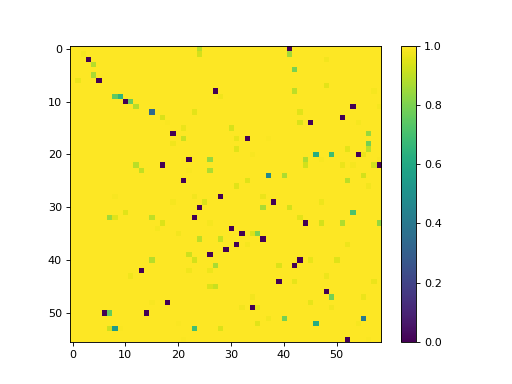

In [120]:
print D.shape
pl.figure()
pl.imshow(D)
pl.colorbar()

In [123]:
D[D>options['dist_thr']] = np.inf

<IPython.core.display.Javascript object>


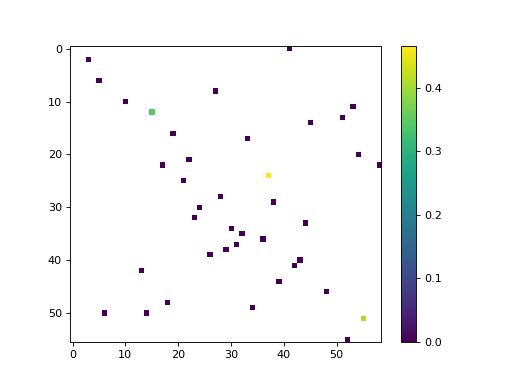

In [125]:
pl.figure()
pl.imshow(D)
pl.colorbar()

In [ ]:
%timeit match_1, match_2 = scipy.optimize.linear_sum_assignment(D)

In [ ]:
from scikit-learn

In [ ]:
matched_ROIs = [match_1, match_2]
nonmatched_1 = np.setdiff1d(np.arange(0, K1), match_1)
nonmatched_2 = np.setdiff1d(np.arange(0, K2), match_2)